# Benchmark: Manns Lab Patient Dataset

In this notebook, we will explore a human patient dataset. Brain tissue from each patient has been extracted, and proteins in each tissue have been identified and intensities quantified.
We have access to two datasets, "PILOT" and "MAIN". PILOT contains a subset of the patients in MAIN. PILOT has fewer missing intensities than MAIN. Thus, we'll use PILOT as the validation set and MAIN as the training set.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch
from scipy.stats import spearmanr, pearsonr

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import manns_lab_support as sup
from scp.models import PROTVI
import scp.plots as pl
import scp.utils

import scvi

np.random.seed(0)
torch.manual_seed(0)
scvi.settings.seed = 0

Global seed set to 0


Let"s define the paths.

In [2]:
MAIN_DIR = "../data/manns_lab/MAIN/"
PILOT_DIR = "../data/manns_lab/PILOT/"

## Data Exploration

Let"s load the data.

In [3]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    main_adata = sup.load_main_data(MAIN_DIR)
    main_adata = sup.preprocess(main_adata)

    pilot_adata = sup.load_pilot_data(PILOT_DIR)
    pilot_adata = sup.preprocess(pilot_adata)

input: (5045, 2703)
sc.pp.filter_genes: (5045, 2703)
sc.pp.filter_cells: (5045, 2703)
filter: (4566, 2018)
input: (461, 3306)
sc.pp.filter_genes: (461, 3305)
sc.pp.filter_cells: (461, 3305)
filter: (454, 2963)


In [4]:
adata = sup.combine_PILOT_and_MAIN(pilot_adata, main_adata)

Nr. patients | main: 4566, pilot: 454, in both: 447
Nr. proteins | main: 2018, pilot: 2963, in both: 1783


In [5]:
sup.print_combined_summary(adata)

Percentage of patients in both PILOT and MAIN (patients: 447):
  2018 unique proteins (all those in MAIN):      76.32%
  1783 unique proteins (in both MAIN and PILOT): 86.38%

Percentage of observed intensities using MAIN patient-protein layout (patients: 4566, proteins: 2018)
  MAIN:     69.66%
  PILOT:    7.47%
  combined: 71.28%


In [6]:
adata.layers["MAIN_missing_as_nan"] = adata.layers["MAIN"].copy()
del adata.layers["MAIN"]

adata.layers["PILOT_missing_as_nan"] = adata.layers["PILOT"].copy()
del adata.layers["PILOT"]

adata.layers["combined_missing_as_nan"] = adata.layers["combined"].copy()
del adata.layers["combined"]

After filtering the data, we end up with:

In [7]:
adata

AnnData object with n_obs × n_vars = 4566 × 2018
    obs: 'Run', 'Experiment', 'Sex', 'Age', 'MSgroup', 'Diagnosis_group', 'Diagnosis_group_subtype', 'Diagnosis_group_autoimmune_split', 'RMS_PMS', 'Plate', 'Preparation day', 'Sample_position', 'Sample_row', 'Sample_column', 'Leukocyte count', 'Leukocyte_count_log2', 'Erythrocytes', 'Total protein', 'Total_protein_log2', 'Albumin CSF', 'Albumin_CSF_log2', 'Qalb', 'QAlb_log2', 'Diff_age_adj_QAlb', 'Diff_age_adj_QAlb_log2', 'IgG CSF', 'IgG_CSF_log2', 'QIgG', 'QIgG_log2', 'Sample_injection_number', 'Sample_injection_order', 'Sample_plate_order', 'Sample_plate_order_inCrossSectional', 'Depth_PG', 'Depth_Gene', 'EvoSep', 'LC_column', 'Emitter', 'Capillary', 'MS_calibration', 'Evosept', 'Column', 'Maintenance', 'log Qalb', 'File.Name', 'Precursors.Identified', 'Proteins.Identified', 'Total.Quantity', 'MS1.Signal', 'MS2.Signal', 'FWHM.Scans', 'FWHM.RT', 'Median.Mass.Acc.MS1', 'Median.Mass.Acc.MS1.Corrected', 'Median.Mass.Acc.MS2', 'Median.Mass

In the intensity-based expression matrix, each obs is a patient and each "var" is a protein.

**Interesting patient specific attributes:**
* Diagnosis_group: the diagnosis of the patient
* Qalb  and IgG CSF: Serum quotient of albumin (Qalb) and the cerebrospinal fluid (CSF) are the most used biomarker for the evaluation of blood–cerebrospinal fluid barrier (B-CSF-B) permeability. They are age- and sex-related.


In [8]:
adata.obs.head()

,Run,Experiment,Sex,Age,MSgroup,Diagnosis_group,Diagnosis_group_subtype,Diagnosis_group_autoimmune_split,RMS_PMS,Plate,...,Median.Mass.Acc.MS1.Corrected,Median.Mass.Acc.MS2,Median.Mass.Acc.MS2.Corrected,MS2.Mass.Instability,Normalisation.Instability,Median.RT.Prediction.Acc,Average.Peptide.Length,Average.Peptide.Charge,Average.Missed.Tryptic.Cleavages,n_genes
ID,,,,,,,,,,,,,,,,,,,,,
01_A_03,20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_...,cross-sectional,F,24.0,nonMS,Headache,NaN,Headache,NaN,plate1,...,1.87526,3.90571,2.57315,0,0.161620,0.026961,13.827,2.341,0.168,1601
01_A_04,20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_...,cross-sectional,M,53.0,nonMS,Neurodegenerative,NaN,Neurodegenerative,NaN,plate1,...,1.84340,3.77452,2.65587,0,0.246424,0.027870,13.820,2.340,0.173,1694
01_A_05,20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_...,cross-sectional,M,55.0,nonMS,Other,NaN,Other,NaN,plate1,...,1.78942,3.41259,2.42294,0,0.084540,0.029365,14.330,2.391,0.212,1516
01_A_06,20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_...,cross-sectional,M,33.0,nonMS,Other,NaN,Other,NaN,plate1,...,1.82053,3.38577,2.51288,0,0.138253,0.029304,14.312,2.388,0.196,1572
01_A_07,20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_...,cross-sectional,F,26.0,MS,MS,RMS,MS,RMS,plate1,...,1.82249,3.43340,2.55149,0,0.226453,0.032779,13.588,2.335,0.174,1521


Let"s look at the distribution of some of the patient features.

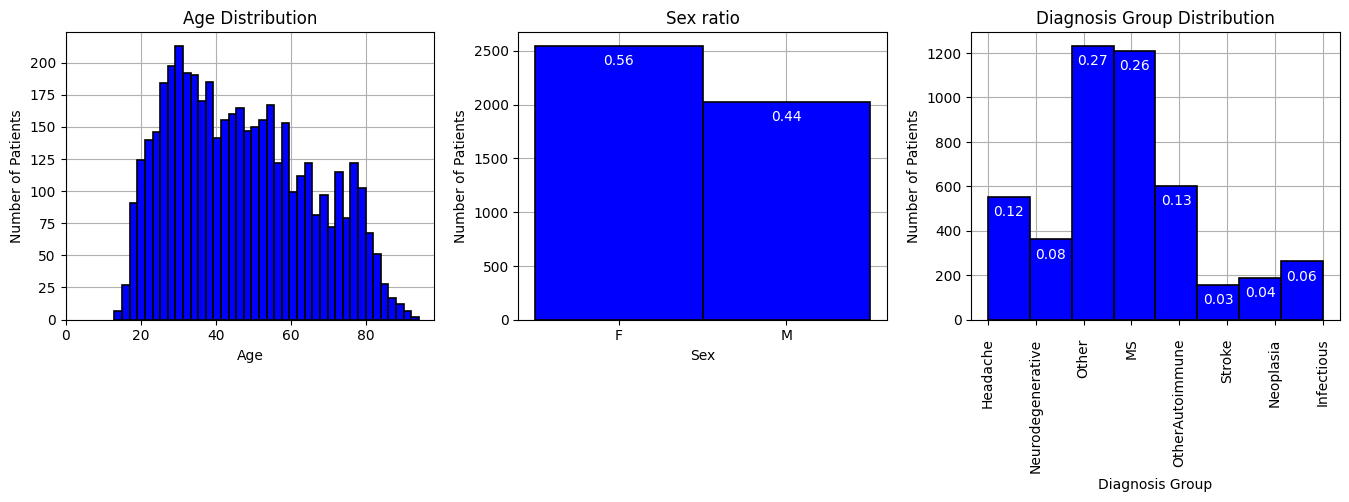

In [9]:
fig, axes = plt.subplots(figsize=(14, 4), nrows=1, ncols=3)
fig.tight_layout(pad=3.0)

# age
ax = axes[0]
ax.hist(adata.obs["Age"], bins=40, color="blue", edgecolor="black", linewidth=1.2)
ax.set_xlabel("Age")
ax.set_ylabel("Number of Patients")
ax.set_title("Age Distribution")
ax.set_xlim([0, None])
ax.grid(True)
ax.set_axisbelow(True)

# sex
ax = axes[1]
ax.hist(adata.obs["Sex"], bins=2, color="blue", edgecolor="black", linewidth=1.2)
ax.set_xlabel("Sex")
ax.set_ylabel("Number of Patients")
ax.set_title("Sex ratio")
ax.set_xticks([0.25, 0.75])
ax.grid(True)
ax.set_axisbelow(True)

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height - 200, f"{height / len(adata.obs):.2f}", ha="center", va="bottom", color="white")

# diagnosis group
ax = axes[2]
N_bins = len(adata.obs["Diagnosis_group"].unique())
ax.hist(adata.obs["Diagnosis_group"], bins=N_bins, color="blue", edgecolor="black", linewidth=1.2)
ax.set_xlabel("Diagnosis Group")
ax.set_ylabel("Number of Patients")
ax.set_title("Diagnosis Group Distribution")

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height - 100, f"{height / len(adata.obs):.2f}", ha="center", va="bottom", color="white")

ax.tick_params(axis="x", pad=10)
ax.grid(True)
ax.set_axisbelow(True)


Recall, the biomarkers are age related. Let's see if that is true for this dataset.

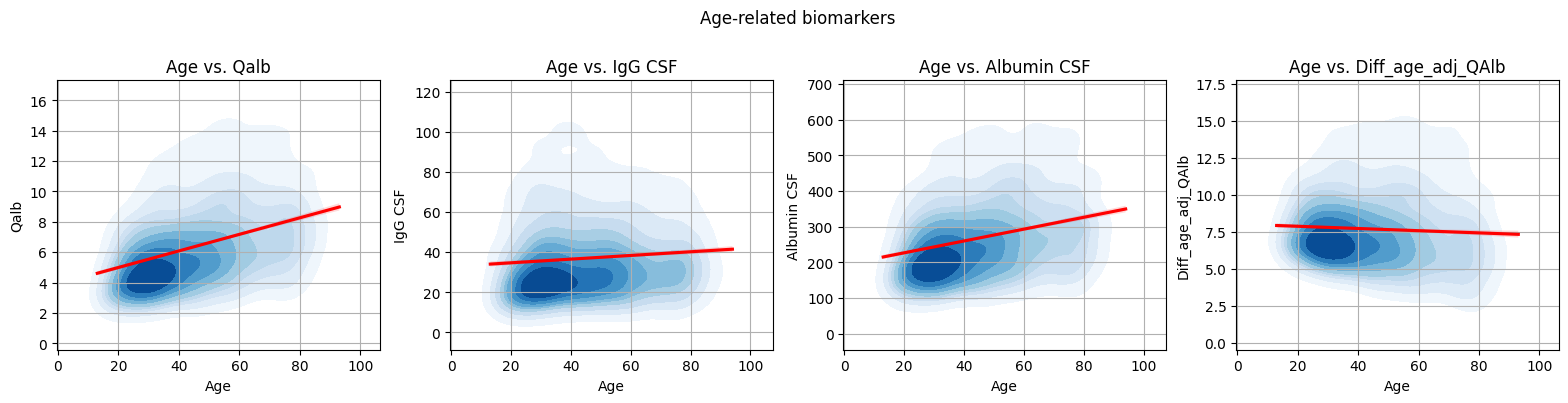

In [10]:
biomarkers = ["Qalb", "IgG CSF", "Albumin CSF", "Diff_age_adj_QAlb"]

N_cols = len(biomarkers)

fig, axes = plt.subplots(ncols=N_cols, nrows=1, figsize=(16, 4))
fig.suptitle("Age-related biomarkers")
fig.tight_layout(pad=2.0)

for i, biomarker in enumerate(biomarkers):
    biomarker_sub = adata[adata.obs[biomarker] < adata.obs[biomarker].quantile(0.95), :]
    
    ax = axes[i]
    #ax.scatter(x=subset.obs["Age"], y=subset.obs[biomarker], color="blue", alpha=1, s=1)
    sns.kdeplot(x=biomarker_sub.obs["Age"], y=biomarker_sub.obs[biomarker], cmap="Blues", shade=True, shade_lowest=False, ax=ax)
    sns.regplot(x=biomarker_sub.obs["Age"], y=biomarker_sub.obs[biomarker], ax=ax, scatter=False, color="red")
    ax.set_xlabel("Age")
    ax.set_ylabel(biomarker)
    ax.set_title("Age vs. {}".format(biomarker))
    ax.grid(True)

Let's check if Qalb and intensity missingess is correlated.

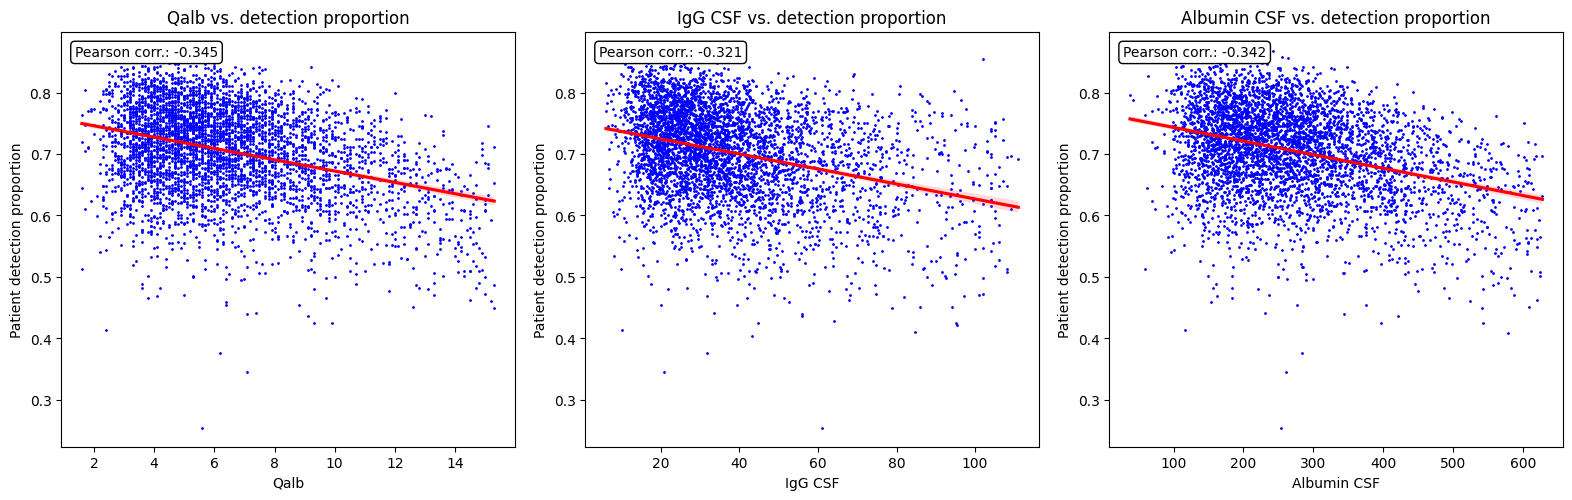

In [11]:
biomarkers = ["Qalb", "IgG CSF", "Albumin CSF"]
N_cols = len(biomarkers)

x_main = adata.layers["MAIN_missing_as_nan"]
p_patient = np.sum(~np.isnan(x_main), axis=1) / x_main.shape[1]

fig, axes = plt.subplots(ncols=N_cols, nrows=1, figsize=(16, 5))
fig.tight_layout(pad=2.0)

for i, biomarker in enumerate(biomarkers):
    quantile_filter = adata.obs[biomarker] < adata.obs[biomarker].quantile(0.95)
    biomarker_sub = adata[quantile_filter, :].obs[biomarker]
    p_patient_sub = p_patient[quantile_filter]

    ax = axes[i]
    pearson_corr, _ = pearsonr(biomarker_sub, p_patient[quantile_filter])
    ax.text(0.03, 0.94, f"Pearson corr.: {pearson_corr:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)
    ax.scatter(x=biomarker_sub, y=p_patient_sub, color="blue", alpha=1, s=1)
    sns.regplot(x=biomarker_sub, y=p_patient_sub, ax=ax, scatter=False, color="red")
    
    ax.set_xlabel(biomarker)
    ax.set_ylabel("Patient detection proportion")
    ax.set_title("{} vs. detection proportion".format(biomarker))


This is correlation is not surprising as these biomarkers are related to the blood–cerebrospinal fluid barrier - a thin barrier may lead to "contamination" of the CSF with blood cells.

Let"s look at the distribution of the protein features.

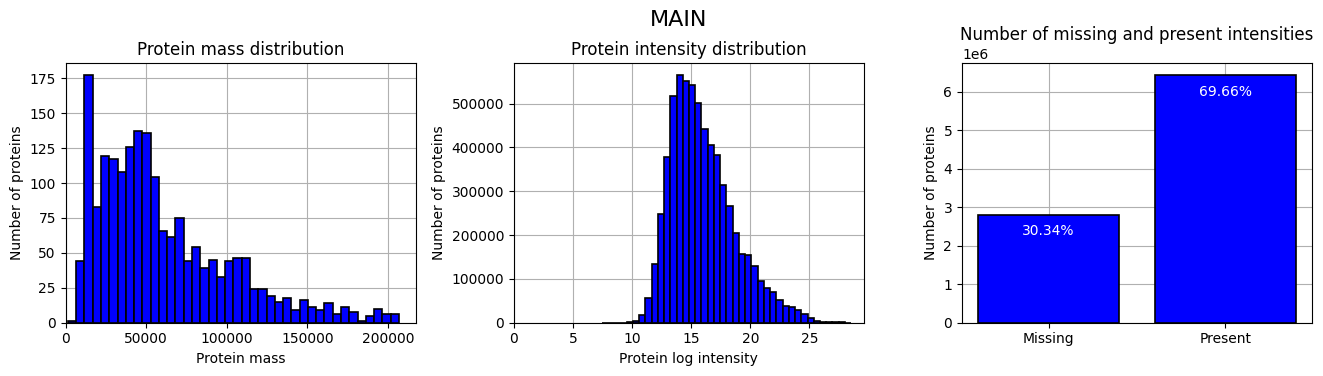

In [12]:
x_main = adata.layers["MAIN_missing_as_nan"]

fig, axes = plt.subplots(figsize=(14, 4), nrows=1, ncols=3)
fig.tight_layout(pad=4.0)
fig.suptitle("MAIN", fontsize=16)

ax = axes[0]
biomarker_sub = adata[:, adata.var["Mass"] < adata.var["Mass"].quantile(0.95)]
ax.hist(biomarker_sub.var["Mass"], bins=40, color="blue", edgecolor="black", linewidth=1.2)
ax.set_xlabel("Protein mass")
ax.set_ylabel("Number of proteins")
ax.set_title("Protein mass distribution")
ax.set_xlim([0, None])
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
intensities = x_main[~np.isnan(x_main)]
ax.hist(intensities, bins=40, color="blue", edgecolor="black", linewidth=1.2)
ax.set_xlabel("Protein log intensity")
ax.set_ylabel("Number of proteins")
ax.set_title("Protein intensity distribution")
ax.set_xlim([0, None])
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[2]
N_missing = np.isnan(x_main).sum()
N_present = (~np.isnan(x_main)).sum()
N_total = N_missing + N_present
ax.bar(["Missing", "Present"], [N_missing, N_present], color="blue", edgecolor="black", linewidth=1.2)
ax.set_ylabel("Number of proteins")
ax.set_title("Number of missing and present intensities")
ax.grid(True)
ax.set_axisbelow(True)

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height - 6e5, f"{height / N_total* 100:.2f}%", ha="center", va="bottom", color="white")

Let's look at at detection probabilities given the avg. intensity for each protein.

/tmp/ipykernel_11914/320098889.py:19: RuntimeWarning: Mean of empty slice
  x_obs_protein = np.nanmean(x_main, axis=0)


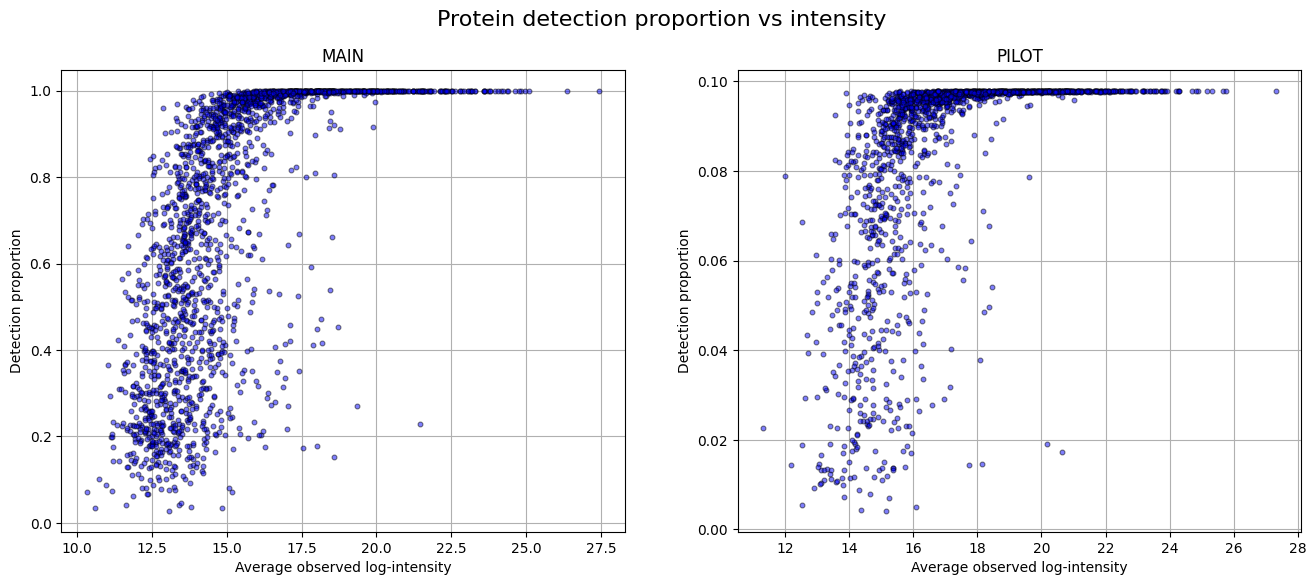

In [13]:
fig, axes = plt.subplots(figsize=(16, 6), ncols=2)
fig.suptitle("Protein detection proportion vs intensity", fontsize=16)

# MAIN
x_main = adata.layers["MAIN_missing_as_nan"]
x_obs_protein = np.nanmean(x_main, axis=0)
p_protein = 1 - np.mean(np.isnan(x_main), axis=0)

ax = axes[0]
ax.scatter(x_obs_protein, p_protein, color="blue", edgecolor="black", linewidth=.8, s=12, alpha=0.5)
ax.set_title("MAIN")
ax.set_xlabel("Average observed log-intensity")
ax.set_ylabel("Detection proportion")
ax.grid(True)
ax.set_axisbelow(True)

# PILOT
x_main = adata.layers["PILOT_missing_as_nan"]
x_obs_protein = np.nanmean(x_main, axis=0)
p_protein = 1 - np.mean(np.isnan(x_main), axis=0)

ax = axes[1]
ax.scatter(x_obs_protein, p_protein, color="blue", edgecolor="black", linewidth=.8, s=12, alpha=0.5)
ax.set_title("PILOT")
ax.set_xlabel("Average observed log-intensity")
ax.set_ylabel("Detection proportion")
ax.grid(True)
ax.set_axisbelow(True)

## PROTVI

### Training

Let's now train the model.

In [14]:
x_tmp = adata.layers["MAIN_missing_as_nan"].copy()
x_tmp[np.isnan(x_tmp)] = 0
adata.layers["MAIN_missing_as_zero"] = x_tmp.copy()

In [15]:
PROTVI.setup_anndata(adata, layer="MAIN_missing_as_zero", batch_key="Plate")

model = PROTVI(adata, log_variational=False, n_latent=16)
#model.view_anndata_setup()

Let's train the model.

In [16]:
model.train(max_epochs=400)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [05:08<00:00,  1.31it/s, v_num=1, train_loss_step=1.9e+3, train_loss_epoch=1.53e+3] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [05:08<00:00,  1.30it/s, v_num=1, train_loss_step=1.9e+3, train_loss_epoch=1.53e+3]


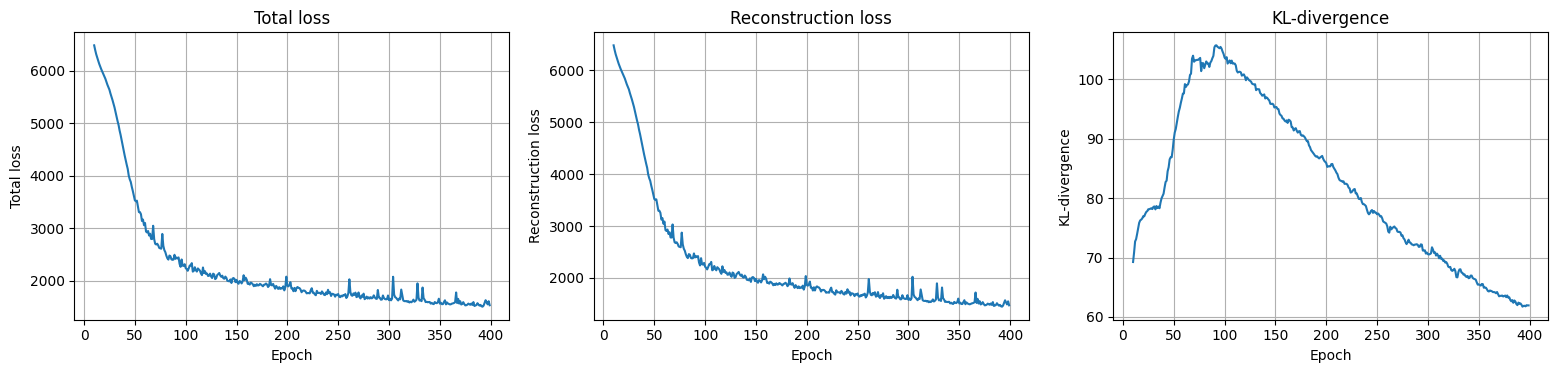

In [17]:
pl.plot_loss(model.history, n_skip=10)

### Evaluation on training set (MAIN)

In [18]:
x_est, p_est = model.impute()

x_main = adata.layers["MAIN_missing_as_nan"]

x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_main)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_main)] = np.nan

Let's look at the predicted detection probability for each protein, and compare it to the observed missingness.

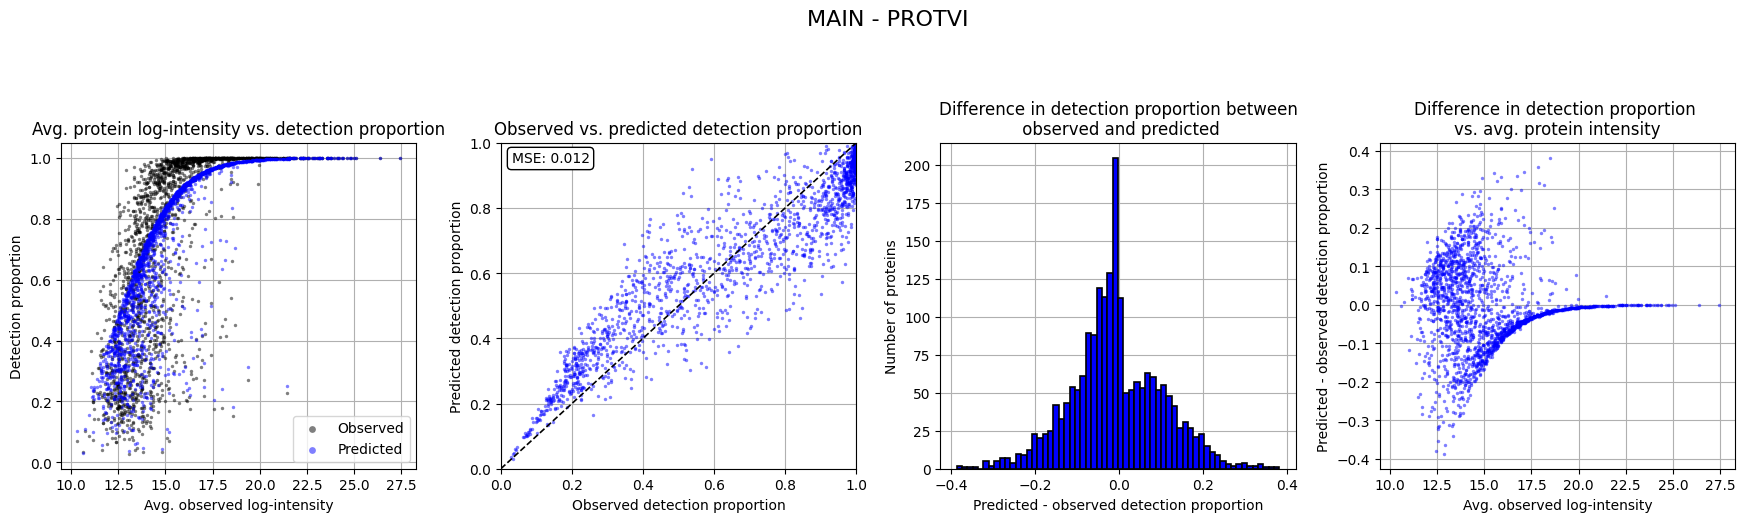

In [19]:
pl.plot_protein_detection_probability_panel(x_main, p_est, title="MAIN - PROTVI")

Let's now compare the protein intensities predicted by the model and the intensities in MAIN.

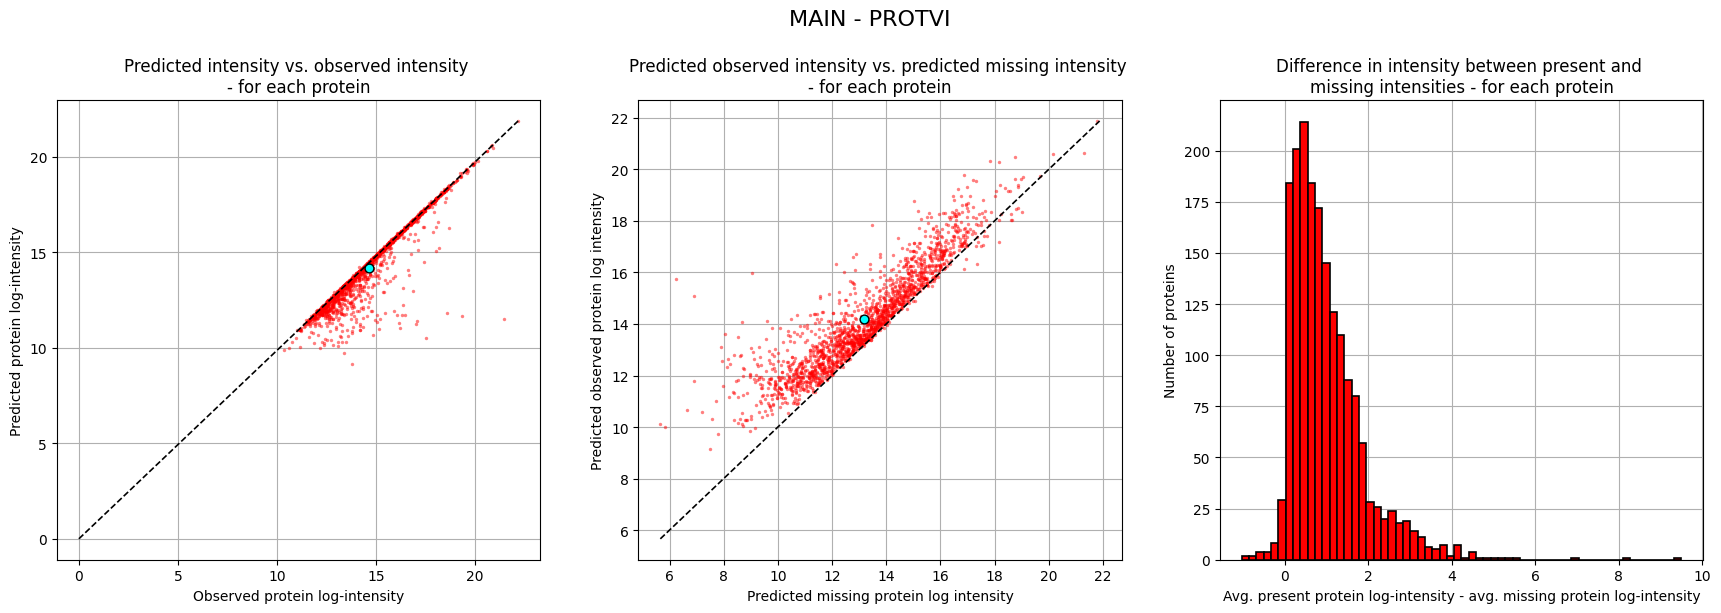

In [20]:
pl.plot_protein_intensity_panel(x_main, x_est, title="MAIN - PROTVI")

Let's look at the latent space.

In [21]:
latent = model.get_latent_representation()
adata.obsm["latent"] = latent

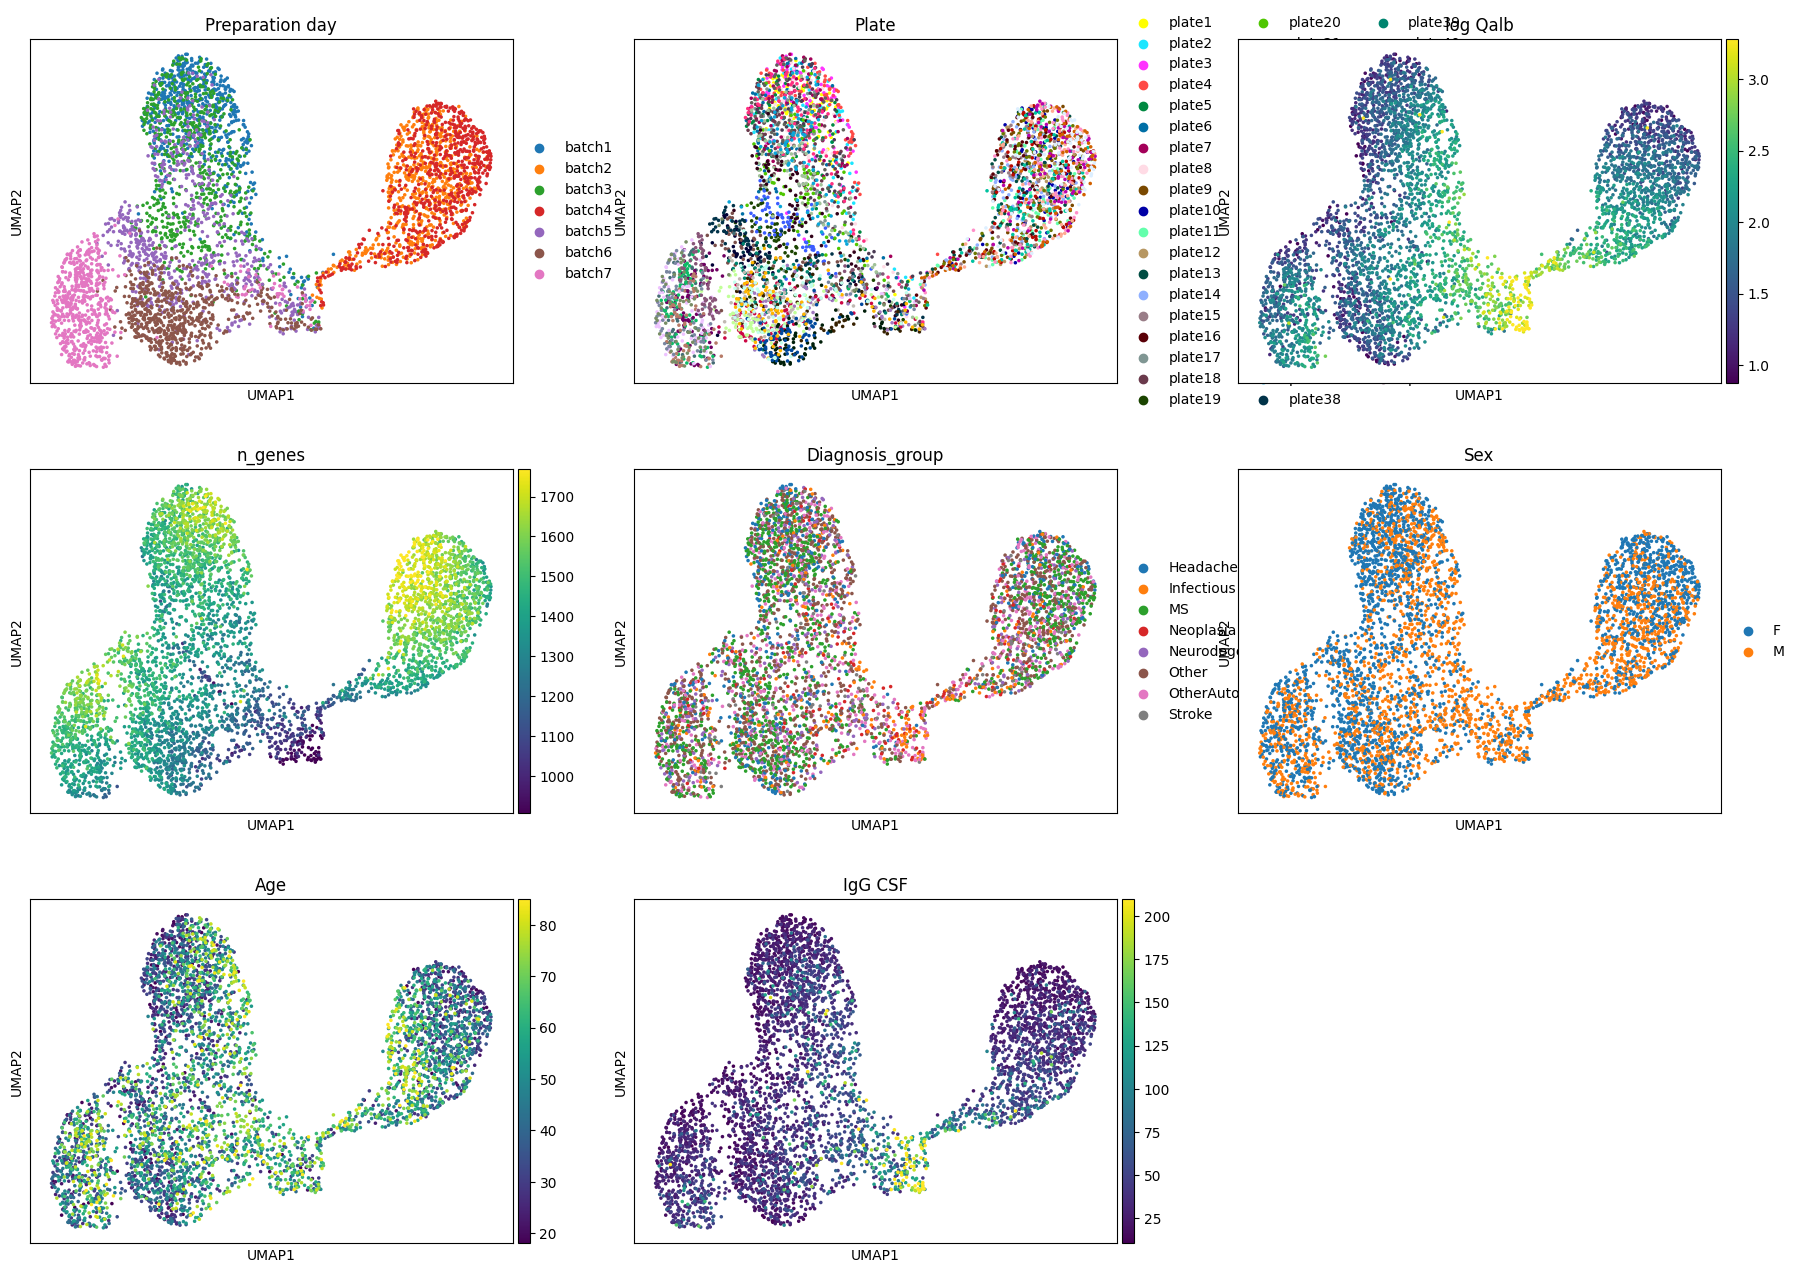

In [22]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)

sc.pl.umap(
    adata, 
    color=["Preparation day", "Plate", "log Qalb", "n_genes", "Diagnosis_group", "Sex", "Age", "IgG CSF"], 
    vmin="p01", vmax="p99",
    ncols=3,
)

### Evaluation on validation set (PILOT)

In [23]:
x_pilot = adata.layers["PILOT_missing_as_nan"]

in_pilot_mask = ~np.isnan(x_pilot)
miss_mask = np.logical_and(np.isnan(adata.layers["MAIN_missing_as_nan"]), in_pilot_mask)
obs_mask = np.logical_and(~np.isnan(adata.layers["MAIN_missing_as_nan"]), in_pilot_mask)

In [24]:
protein_mask = miss_mask.any(axis=0)

x_est_miss2 = x_est_miss.copy()
x_est_miss2[~miss_mask] = np.nan
x_est_miss2 = x_est_miss2[:, protein_mask]

x_pilot2 = x_pilot.copy()
x_pilot2[~miss_mask] = np.nan
x_pilot2 = x_pilot2[:, protein_mask]

x_est_protein2 = np.nanmean(x_est_miss2, axis=0)
x_pilot_protein2 = np.nanmean(x_pilot2, axis=0)

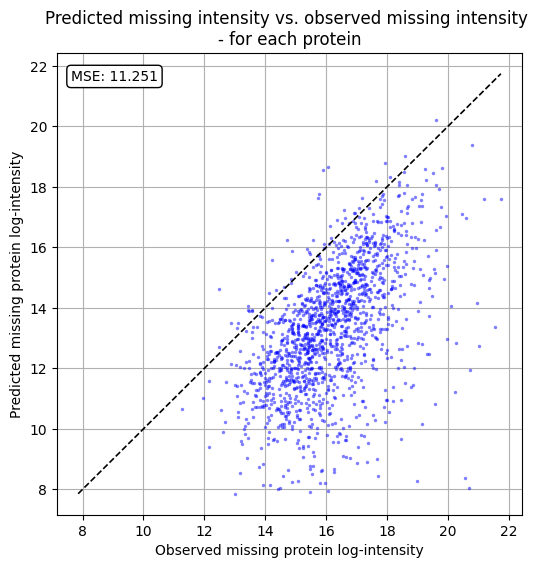

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(x_pilot_protein2, x_est_protein2, color="blue", edgecolor="black", linewidth=0, s=6, alpha=0.5)
v_min = min(x_pilot_protein2.min(), x_est_protein2.min())
v_max = max(x_pilot_protein2.max(), x_est_protein2.max())
ax.plot([v_min, v_max], [v_min, v_max], color="black", linewidth=1.2, linestyle="--")

mse = np.mean((x_pilot_protein2 - x_est_protein2) ** 2)
ax.text(0.03, 0.94, f"MSE: {mse:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)

ax.set_xlabel("Observed missing protein log-intensity")
ax.set_ylabel("Predicted missing protein log-intensity")
ax.set_title("Predicted missing intensity vs. observed missing intensity \n- for each protein")
ax.grid(True)
ax.set_axisbelow(True)

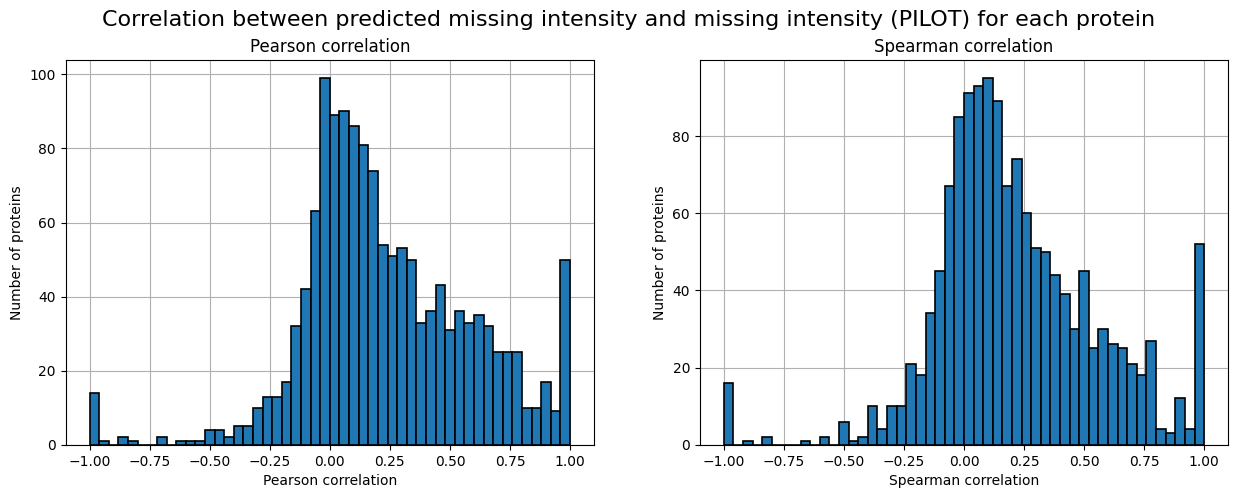

In [26]:
pearson_corr = []
spearman_corr = []

# keep proteins with > 1 intensities
duplicate_protein_indices, = np.where(miss_mask.sum(axis=0) > 1)

for i in duplicate_protein_indices:
    intensity_main = x_est[:,i][miss_mask[:,i]]
    intensity_pilot = adata.layers["PILOT_missing_as_nan"][:,i][miss_mask[:,i]]
    
    pearson_corr.append(pearsonr(intensity_main, intensity_pilot)[0])
    spearman_corr.append(spearmanr(intensity_main, intensity_pilot)[0])

fig, axes = plt.subplots(figsize=(15, 5), ncols=2)
fig.suptitle("Correlation between predicted missing intensity and missing intensity (PILOT) for each protein", fontsize=16)

ax = axes[0]
ax.hist(pearson_corr, bins=50, edgecolor="black", linewidth=1.2)
ax.set_title("Pearson correlation")
ax.set_xlabel("Pearson correlation")
ax.set_ylabel("Number of proteins")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
ax.hist(spearman_corr, bins=50, edgecolor="black", linewidth=1.2)
ax.set_title("Spearman correlation")
ax.set_xlabel("Spearman correlation")
ax.set_ylabel("Number of proteins")
ax.grid(True)
ax.set_axisbelow(True)

## protDP

Let's also train [protDP](https://mengbo-li.github.io/protDP/index.html) for later comparison.

### Training

First, we'll fit protDP to the data.

In [27]:
%%capture
import anndata2ri
anndata2ri.activate()

import rpy2.robjects as robjects
%load_ext rpy2.ipython

In [28]:
r_adata = scp.utils.prepare_anndata_for_R(adata)

In [29]:
%%R -i r_adata
library(protDP)

X <- assay(r_adata, "MAIN_missing_as_nan")
dpcfit <- dpc(X)

In [30]:
protdp_result = robjects.r("dpcfit")

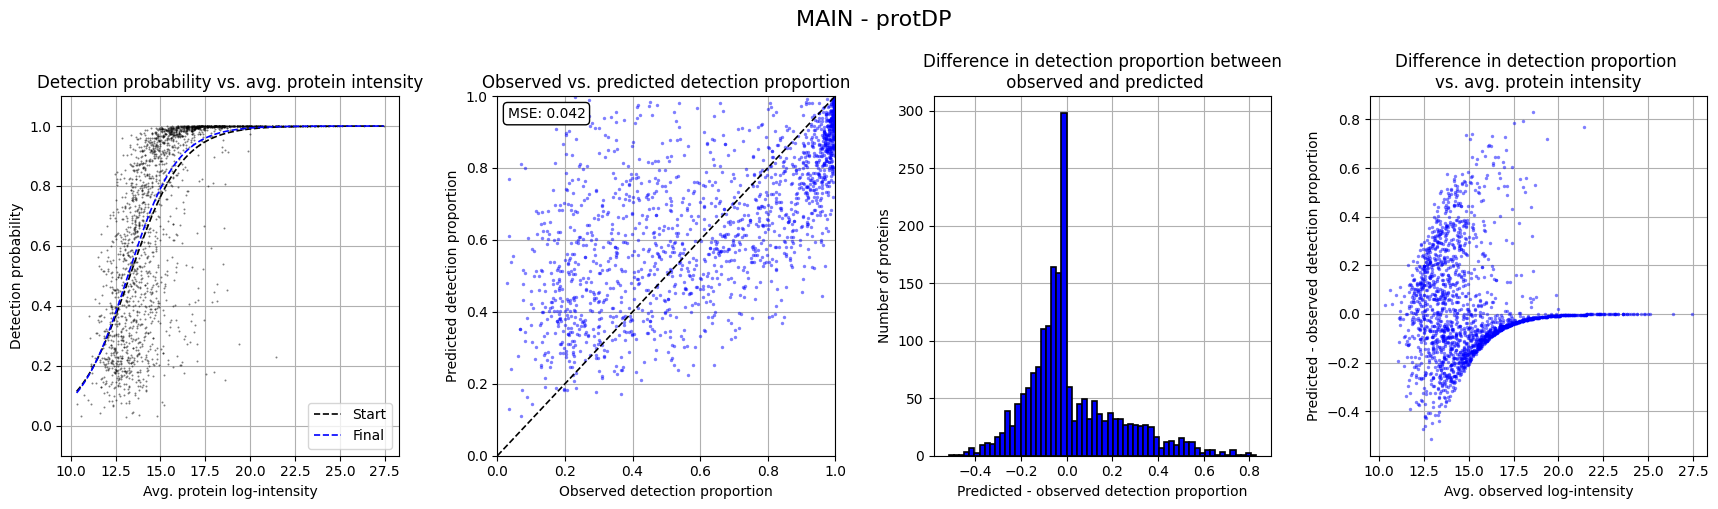

In [31]:
pl.plot_protein_detection_probability_panel_protDP(x_main, protdp_result, title="MAIN - protDP")

In [32]:
protein_mask = miss_mask.any(axis=0)

x_pilot2 = x_pilot.copy()
x_pilot2[~miss_mask] = np.nan
x_pilot2 = x_pilot2[:, protein_mask]

x_est_protein2 = protdp_result["mu_mis"][protein_mask]
x_pilot_protein2 = np.nanmean(x_pilot2, axis=0)

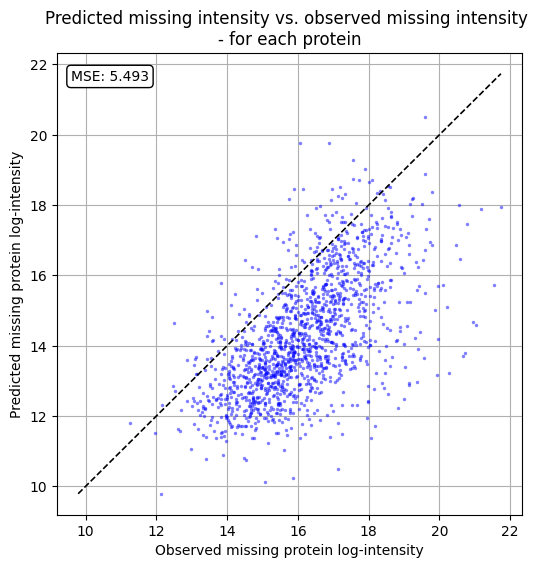

In [33]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(x_pilot_protein2, x_est_protein2, color="blue", edgecolor="black", linewidth=0, s=6, alpha=0.5)
v_min = min(x_pilot_protein2.min(), x_est_protein2.min())
v_max = max(x_pilot_protein2.max(), x_est_protein2.max())
ax.plot([v_min, v_max], [v_min, v_max], color="black", linewidth=1.2, linestyle="--")

mse = np.mean((x_pilot_protein2 - x_est_protein2) ** 2)
ax.text(0.03, 0.94, f"MSE: {mse:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)

ax.set_xlabel("Observed missing protein log-intensity")
ax.set_ylabel("Predicted missing protein log-intensity")
ax.set_title("Predicted missing intensity vs. observed missing intensity \n- for each protein")
ax.grid(True)
ax.set_axisbelow(True)

### protDP vs PROTVI

Let's compare the results of the two methods:

/tmp/ipykernel_11914/1087231902.py:8: RuntimeWarning: Mean of empty slice
  x_est_mis_protein = np.nanmean(x_est_miss, axis=0)


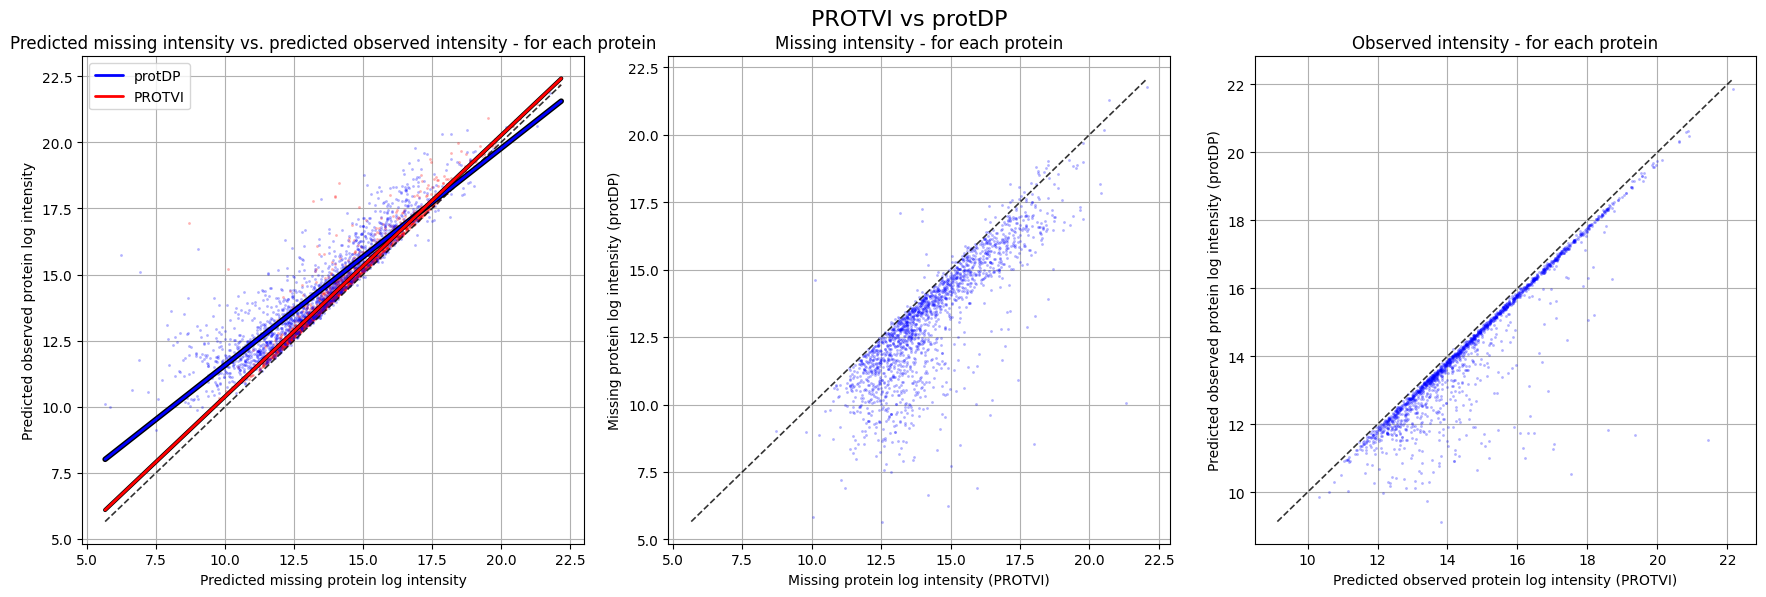

In [36]:
x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_main)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_main)] = np.nan

x_est_obs_protein = np.nanmean(x_est_obs, axis=0)
x_est_mis_protein = np.nanmean(x_est_miss, axis=0)

pl.plot_model_intensity_comparison(
    x_main, 
    protdp_result["mu_obs"], 
    protdp_result["mu_mis"],
    x_est_obs_protein, 
    x_est_mis_protein,
    "protDP",
    "PROTVI"
)